# Intro:
1) These below blocks of code was implemented as excersice of the classification chapter from Hands on ML book by Oreilly

In [15]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1)
# mnist.keys()
X_df,y_df = mnist['data'],mnist['target'].astype(np.uint8)
X,y = mnist['data'].to_numpy() , mnist['target'].to_numpy().astype(np.uint8)

#split into train & test sets
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]
X_train_df,y_train_df,X_test_df,y_test_df = X_df[:60000],y_df[:60000],X_df[60000:],y_df[60000:]

# Data Analysis

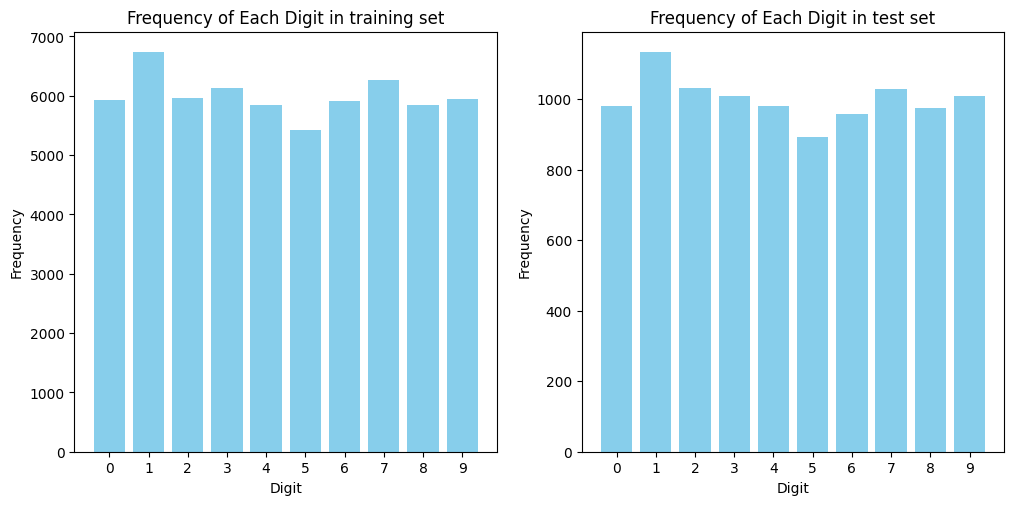

In [2]:
"""checking frequency of each unique digit"""

import matplotlib.pyplot as plt
#count the occurences of each digit
unique_train,counts_train = np.unique(y_train_df,return_counts=True)
unique_test,counts_test = np.unique(y_test_df,return_counts=True)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.bar(unique_train,counts_train,color='skyblue')
plt.title('Frequency of Each Digit in training set')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.xticks(unique_train)

plt.subplot(2,2,2)
plt.bar(unique_test,counts_test,color='skyblue')
plt.title('Frequency of Each Digit in test set')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.xticks(unique_test)

plt.show()

# Insights
1) As train and test sets have nearly same distribution in every class. the data is already stratified. 

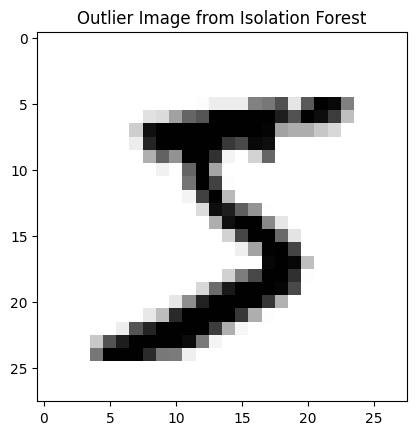

<class 'pandas.core.series.Series'>
Index: 600 entries, 28 to 59669
Series name: class
Non-Null Count  Dtype
--------------  -----
600 non-null    uint8
dtypes: uint8(1)
memory usage: 5.3 KB


In [19]:
"""Checking For Outliers:
Isolation Forest is a good approach for detecting outliers across the entire
dataset when there are multiple features(multi-dimensional dataset like mnist).
"""
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01) #assume 1% of the data as outliers
outliers = iso_forest.fit_predict(X_train)

#convert the -1 label (outliers) to actual class
outliers_data = X_train_df.iloc[outliers==1]
outliers_labels = y_train_df.iloc[outliers==-1]

#Visualize one of the outlier images
outlier_img = outliers_data.iloc[0].values.reshape(28,28)
plt.imshow(outlier_img,cmap='binary')
plt.title("Outlier Image from Isolation Forest")
plt.show()

#handling outliers:

# 1) removing them if they are faulty or don't represent true patterns or invalid digit
# X_clean = X.iloc[outliers != -1]
# y_clean = y.iloc[outliers != -1]

#2) manually label them and add them to your training data if they are important or intresting and became an
#outlier cause difficulty in predicting it.
# outliers_labels.head() #check misclasified labels 


#3) use outliers for semi-supervised learning:
# # You could use clustering techniques (like K-Means) on the outliers to further analyze them
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=2)  # Example: clustering the outliers into two groups
# outlier_clusters = kmeans.fit_predict(outliers_data)

#4)Keep outliers for specialized models(anomaly detection models)

outliers_labels.info() #check misclasified labels 



# Insights
1) the Number of outliers are less(600). so no need of scaling.

2) NO categorical cols hence no need of encoding

# Training

In [2]:
#training the KNN model
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)

KNeighborsClassifier()

# Evaluation

[4] 4


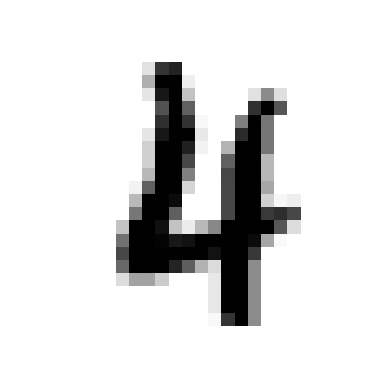

In [34]:
#prediction check with visualizing
n =109
print(knn_clf.predict([X_train[n]]), y_train[n])

import matplotlib.pyplot as plt
    
# Plot digit function
def plot_digit(digit_data):
        digit_image = digit_data.reshape(28, 28)
        plt.imshow(digit_image, cmap='binary')
        plt.axis('off')
        plt.show()

plot_digit(X_train[n])

In [8]:
# checking metrics
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_predict,cross_val_score
print(cross_val_score(knn_clf,X_train,y_train,cv=3,scoring='accuracy'))


[0.9676  0.9671  0.96755]


Precision Score:  0.967895609653832
Recall Score:  0.9669341316176434
f1 Score:  0.9672164755274893


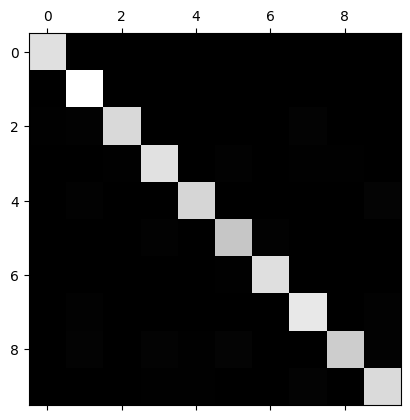

In [13]:
y_train_preds = cross_val_predict(knn_clf,X_train,y_train,cv=3)
print('Precision Score: ', precision_score(y_train,y_train_preds, average='macro'))
print('Recall Score: ', recall_score(y_train,y_train_preds, average='macro'))
print('f1 Score: ', f1_score(y_train,y_train_preds, average='macro'))
cm = confusion_matrix(y_train,y_train_preds)
plt.matshow(cm,cmap=plt.cm.gray)
plt.show()


# insights:
1) precision and recall is good balance
2) 1 is predicted more better than other instances this can be due to more sample of instances in the dataset of 1. 
3) 5 is darker than others cause less samples of 5 in dataset.

# Fine Tuning

In [16]:
# Grid Search for optimal n_neighbors and weights
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors':[3,5,7,9,11,15], #try different k-values
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

knn_clf_2 = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf_2,param_grid,cv=3,
                           n_jobs=-1, verbose=1)

# Reduce dataset size (take only 10% of the data)
from sklearn.model_selection import train_test_split

X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Perform grid search on the smaller dataset
grid_search.fit(X_train_small, y_train_small)


print("Best Parameters: ", grid_search.best_params_)
print("Best Estimators: ", grid_search.best_estimator_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best Estimators:  KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')


# Insights:
1) scikit-learn is a CPU based library. which can't leverage GPU or TPU. but can use cuml if on google colab or NVIDIA GPU device. 
2) Use HalvingGridSearchCV or GridSearchCV(on small training sets to find params) 

# Evaluation

In [28]:
#checking accuracy_score
from sklearn.metrics import accuracy_score

# best_knn  = grid_search.best_estimator_
# best_knn_2 = KNeighborsClassifier(metric='minkowski', n_neighbors=3, weights='distance').fit(X_train_small,y_train_small)
# knn3 = KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='uniform').fit(X_train_small,y_train_small)
knn4 = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='uniform').fit(X_train_small,y_train_small)
 


# knn2preds = best_knn_2.predict(X_train)
# knn3preds = knn3.predict(X_train)
knn4preds = knn4.predict(X_train)



train_accuracy = accuracy_score(y_train,knn4preds)

print(f"train accuracy: {train_accuracy}")


train accuracy: 0.9383


# insights:

1) train acc:
<br>knn2/1 =  0.946
<br>knn3 = 0.936
<br>knn4 = 0.938
<br>knn_clf = 0.96

# Data Augmentation / Training set expansion

In [27]:
# function to shift an MNIST image in four possible directions (left, right, up, down) by one pixel.
import matplotlib.pyplot as plt
def shift_image(image,direction):
    """
    Shift the image by one pixel in the specified direction (left, right, up, down).
    """
    shifted_image = np.zeros_like(image) #when shifting any newly created space is filled with 0's

    if direction=='left':
        shifted_image[:,1:] = image[:,:-1] #shift left (drop 1st col)
    elif direction=='right':
        shifted_image[:,:-1] = image[:,1:] #shift right (drop last col)
    elif direction=='up':
        shifted_image[1:,:] = image[:-1,:] #shift up (drop 1st row)
    elif direction=='down':
        shifted_image[:-1,:] = image[1:,:] #shift down (drop last row)

    return shifted_image        

In [32]:
#Augmenting the Training set
def augment_data(X,y):
    """
    Augment the dataset by creating four shifted copies (left, right, up, down)
    for each image in the training set.
    """
    X_train_aug = []
    y_train_aug  = []

    for i in range(len(X)):
        img = X[i].reshape(28,28)
        label = y[i]

        #Add the original img
        X_train_aug.append(img.flatten())
        y_train_aug.append(label)

        #create shifted images
        for direction in ['left','right','up','down']:
            shifted_img = shift_image(img,direction)
            X_train_aug.append(shifted_img.flatten())
            y_train_aug.append(label)

    return np.array(X_train_aug),np.array(y_train_aug)
    
    

In [33]:
# applying the augmentation
X_train_aug,y_train_aug = augment_data(X_train,y_train)

In [34]:
X_train_aug.shape,y_train_aug.shape,X_train.shape,y_train.shape

((300000, 784), (300000,), (60000, 784), (60000,))

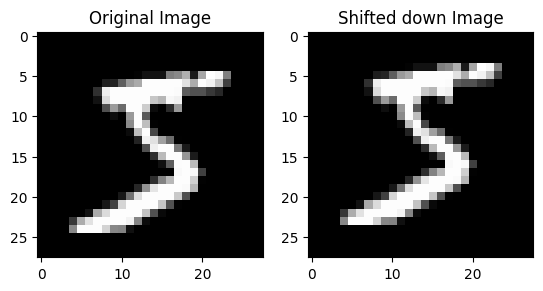

In [38]:
# Example: test the function with a random 28x28 image
image = X_train[0].reshape(28, 28)  # Generate a random 28x28 image
shifted_image_left = shift_image(image, 'down')

# Visualize the original and shifted image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Shifted down Image")
plt.imshow(shifted_image_left, cmap='gray')
plt.show()

In [ ]:
#training knn model
from sklearn.neighbors import KNeighborsClassifier
knn5 = KNeighborsClassifier().fit(X_train_aug,y_train_aug)


In [ ]:
from sklearn.metrics import accuracy_score
knn5preds = knn5.predict(X_train_aug)
train_accuracy = accuracy_score(y_train_aug,knn5preds)

print(f"train accuracy: {train_accuracy}")

# conclusion
1) unable to achieve 97% accuracy. beacuse of small sets do not have stratified representation proportional to the dataset.

2) unable to do heavy duty computation on full training set. hence can't find optimal hyperparams.

3) knn_clf(trained on whole training set) was by far the best model with 96-97% accuracy scores.

4) knn5 model should be more better but due to heavy duty computation it's infeasible to run on my device.